In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import driver
df = driver.sim2(
    ent_arrival_rate=100.0,  # average new entities per month
    ent_lifetime_months=24,  # entities depart after this many months
    subnet_lifetime_months=36,  # subnets depart after this many months
    initial_subnet_revenue=0,  # $100k initial revenue per subnet per month
    max_subnet_revenue=100000,  # $1M max revenue per subnet per month
    revenue_growth_months=48,  # months to reach max revenue
    revenue_burn_pct=0.5,  
    initial_token_price=0.30,  # $0.30 initial token price
    annual_price_growth_rate=0.01,  # 1% annual growth rate
    initial_target_staking_apy=0.08,  # 8% initial target staking APY
    final_target_staking_apy=0.04,  # 4% final target staking APY
    staking_apy_transition_months=48,  # months to transition from initial to final APY
    linear_start_emission=10_000_000,
    linear_end_emission=2_000_000,
    linear_total_emissions=225_000_000,
    dynamic_staking_fees=True,
    max_maintenance_fee_pct=0.5,
)

In [4]:
foundation_breakdown = {
    'ecosystem': 100_000_000,
    'community_infra': 50_000_000,
    'fundraising': 77_000_000,
    'investments': 30_000_000,
    'research': 50_000_000,
}
# of these categories, ecosystem, community_infra, investments, and research are considered
# to be part of the community supply.
# so when we compute the percentage of the total supply for each emission type, we need to
# we take this into acocunt.  since the foundation is vested, 
# we assume all of these components vest at the same rate so we compute percentages.
foundation_to_community_pct = (
    foundation_breakdown['ecosystem'] + 
    foundation_breakdown['community_infra'] + 
    foundation_breakdown['investments'] + 
    foundation_breakdown['research']
) / sum(foundation_breakdown.values())
foundation_remaining_pct = 1 - foundation_to_community_pct


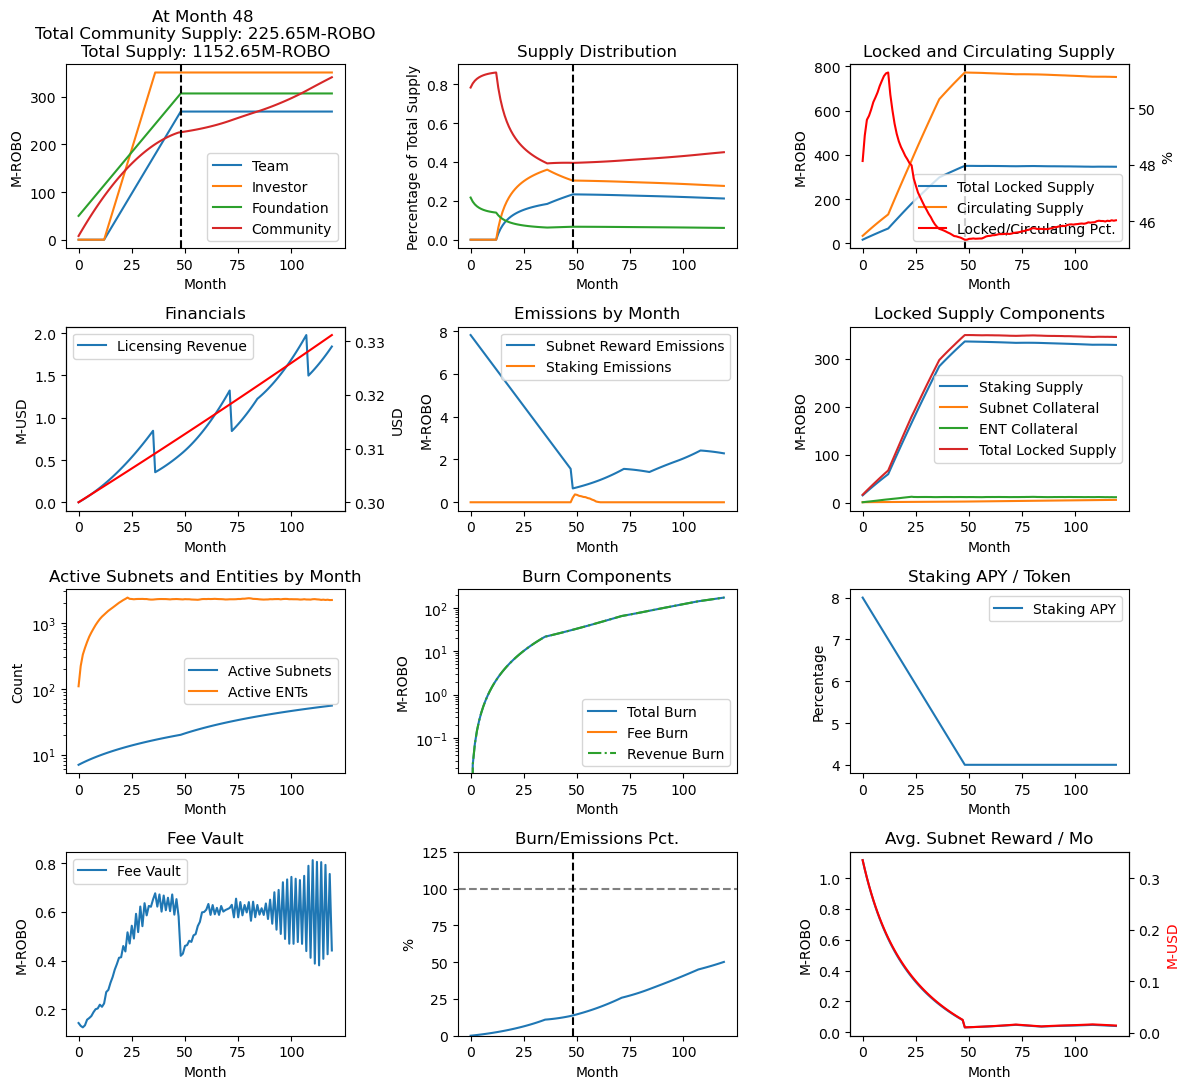

In [5]:
fig, ax = plt.subplots(figsize=(12, 11), nrows=4, ncols=3)

axx = ax[0, 0]
axx.plot(df['month'], df['team_vested']/1e6, label='Team')
axx.plot(df['month'], df['investor_vested']/1e6, label='Investor')
axx.plot(df['month'], df['foundation_vested']/1e6, label='Foundation')
axx.plot(df['month'], df['cumulative_emissions']/1e6, label='Community')
axx.axvline(x=48, color='black', linestyle='--')

# compute the total community supply and total supply at month 48
total_supply_at_48 = df['team_vested'].iloc[48] + df['investor_vested'].iloc[48] + df['foundation_vested'].iloc[48] + df['cumulative_emissions'].iloc[48]
total_community_supply_at_48 = df['cumulative_emissions'].iloc[48]

title_str = f'At Month 48 \nTotal Community Supply: {total_community_supply_at_48/1e6:.2f}M-ROBO\nTotal Supply: {total_supply_at_48/1e6:.2f}M-ROBO'
axx.set_xlabel('Month')
axx.set_ylabel('M-ROBO')
axx.set_title(title_str)
axx.legend()

axx = ax[0, 1]
# compute percentage of the total supply for each emission type
total_supply = df['team_vested'] + df['investor_vested'] + df['foundation_vested'] + df['cumulative_emissions']
team_pct = df['team_vested'] / total_supply
investor_pct = df['investor_vested'] / total_supply
foundation_actual = df['foundation_vested'] * foundation_remaining_pct
foundation_to_community = df['foundation_vested'] * foundation_to_community_pct
foundation_pct = (foundation_actual) / total_supply
community_pct = (df['cumulative_emissions'] + foundation_to_community) / total_supply

axx.plot(df['month'], team_pct, label='Team')
axx.plot(df['month'], investor_pct, label='Investor')
axx.plot(df['month'], foundation_pct, label='Foundation')
axx.plot(df['month'], community_pct, label='Community')
axx.axvline(x=48, color='black', linestyle='--')
axx.set_xlabel('Month')
axx.set_ylabel('Percentage of Total Supply')
axx.set_title('Supply Distribution')

axx = ax[0, 2]
axx.plot(df['month'], df['total_locked_supply']/1e6, label='Total Locked Supply')
axx.plot(df['month'], df['circulating_supply']/1e6, label='Circulating Supply')
axx.axvline(x=48, color='black', linestyle='--')
axx2 = axx.twinx()
axx2.plot(df['month'], df['total_locked_supply']/df['circulating_supply']*100, color='red', label='Locked/Circulating Pct.')
axx.set_xlabel('Month')
axx.set_ylabel('M-ROBO')
axx2.set_ylabel('%')
lines1, labels1 = axx.get_legend_handles_labels()
lines2, labels2 = axx2.get_legend_handles_labels()
axx.legend(lines1 + lines2, labels1 + labels2)
axx.set_xlabel('Month')
axx.set_title('Locked and Circulating Supply')

# show the licensing revenue by month
axx = ax[1, 0]
axx.plot(df['month'], df['licensing_revenue_usd']/1e6, label='Licensing Revenue')
axx.legend()
axx.set_xlabel('Month')
axx.set_ylabel('M-USD')
axx.set_title('Financials')
axx2 = axx.twinx()
axx2.plot(df['month'], df['token_price'], label='Token Price', color='red')
axx2.set_ylabel('USD')

# show emissions by month
axx = ax[1, 1]
axx.plot(df['month'], df['base_emissions']/1e6, label='Subnet Reward Emissions')
axx.plot(df['month'], df['additional_staking_emissions']/1e6, label='Staking Emissions')
axx.legend()
axx.set_xlabel('Month')
axx.set_ylabel('M-ROBO')
axx.set_title('Emissions by Month')

# show the components of locked
axx = ax[1, 2]
axx.plot(df['month'], df['staking_supply']/1e6, label='Staking Supply')
axx.plot(df['month'], df['subnet_collateral']/1e6, label='Subnet Collateral')
axx.plot(df['month'], df['ent_collateral']/1e6, label='ENT Collateral')
axx.plot(df['month'], df['total_locked_supply']/1e6, label='Total Locked Supply')
axx.legend()
axx.set_xlabel('Month')
axx.set_ylabel('M-ROBO')
axx.set_title('Locked Supply Components')

# plot number of subnets and entities by month
axx = ax[2, 0]
axx.plot(df['month'], df['active_subnets'], label='Active Subnets')
axx.plot(df['month'], df['active_ents'], label='Active ENTs')
axx.legend()
axx.set_xlabel('Month')
axx.set_ylabel('Count')
axx.set_title('Active Subnets and Entities by Month')
axx.set_yscale('log')

axx = ax[2, 1]
axx.plot(df['month'], df['cumulative_burn']/1e6, label='Total Burn')
axx.plot(df['month'], df['fee_burn'].cumsum()/1e6, label='Fee Burn')
axx.plot(df['month'], df['revenue_burn_tokens'].cumsum()/1e6, label='Revenue Burn', linestyle='-.')
axx.legend()
axx.set_xlabel('Month')
axx.set_ylabel('M-ROBO')
axx.set_title('Burn Components')
axx.set_yscale('log')

axx = ax[2, 2]
axx.plot(df['month'], df['staking_apy'], label='Staking APY')
axx.legend()
axx.set_xlabel('Month')
axx.set_ylabel('Percentage')
axx.set_title('Staking APY / Token')

axx = ax[3, 0]
axx.plot(df['month'], df['fee_vault']/1e6, label='Fee Vault')
axx.legend()
axx.set_xlabel('Month')
axx.set_ylabel('M-ROBO')
axx.set_title('Fee Vault')

axx = ax[3, 1]
axx.plot(df['month'], df['cumulative_burn']/df['cumulative_emissions']*100)
axx.axhline(y=100, color='grey', linestyle='--')
axx.axvline(x=48, color='black', linestyle='--')
axx.set_xlabel('Month')
axx.set_ylabel('%')
axx.set_title('Burn/Emissions Pct.')
axx.set_ylim(0, 125)
# # Add text labels for deflationary/inflationary zones
# axx.text(0.5, 0.95, 'Deflationary', transform=axx.transAxes, 
#          horizontalalignment='center', verticalalignment='top',
#          fontsize=12, fontweight='bold', color='green')
# axx.text(0.5, 0.05, 'Inflationary', transform=axx.transAxes, 
#          horizontalalignment='center', verticalalignment='bottom',
#          fontsize=12, fontweight='bold', color='red')

axx = ax[3, 2]
axx.plot(df['month'], (df['base_emissions']/1e6)/df['active_subnets'])
axx.set_title('Avg. Subnet Reward / Mo')
axx.set_xlabel('Month')
axx.set_ylabel('M-ROBO')
axx2 = axx.twinx()
axx2.plot(df['month'], df['token_price']*(df['base_emissions']/1e6)/df['active_subnets'], color='red')
axx2.set_ylabel('M-USD', color='red')


plt.tight_layout()
plt.show()

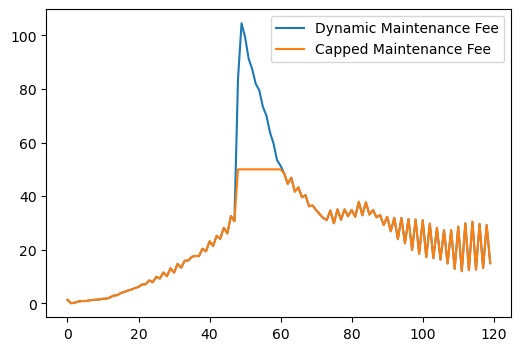

In [6]:
plt.figure(figsize=(6, 4))
plt.plot(df['month'], (df['dynamic_maintenance_fee_pct']*100), label='Dynamic Maintenance Fee')
plt.plot(df['month'], (df['capped_maintenance_fee_pct']*100), label='Capped Maintenance Fee')
# plt.plot(df['month'], (df['static_maintenance_fee_pct']*100).cumsum(), label='Static Maintenance Fee')
plt.legend()
plt.show()

In [8]:
import robo_supply_model
robo_supply_model.print_yearly_subnet_rewards(df)


Total Subnet Rewards by Year:
Year 1: 84,973,404 ROBO (84.97M ROBO)
Year 2: 65,824,468 ROBO (65.82M ROBO)
Year 3: 46,675,532 ROBO (46.68M ROBO)
Year 4: 27,526,596 ROBO (27.53M ROBO)
Year 5: 9,605,944 ROBO (9.61M ROBO)
Year 6: 14,941,077 ROBO (14.94M ROBO)
Year 7: 18,045,241 ROBO (18.05M ROBO)
Year 8: 19,693,499 ROBO (19.69M ROBO)
Year 9: 25,419,447 ROBO (25.42M ROBO)
Year 10: 28,324,221 ROBO (28.32M ROBO)

Total Subnet Rewards by Year (USD):
Year 1: $25,603,898 (avg price: $0.30)
Year 2: $20,031,264 (avg price: $0.30)
Year 3: $14,344,617 (avg price: $0.31)
Year 4: $8,542,234 (avg price: $0.31)
Year 5: $3,013,619 (avg price: $0.31)
Year 6: $4,734,213 (avg price: $0.32)
Year 7: $5,772,464 (avg price: $0.32)
Year 8: $6,364,756 (avg price: $0.32)
Year 9: $8,297,129 (avg price: $0.33)
Year 10: $9,335,380 (avg price: $0.33)

Average Per-Subnet Rewards by Year:
Year 1: 10,009,137 ROBO ($3,015,919) per subnet (avg 8.5 subnets)
Year 2: 5,607,053 ROBO ($1,706,301) per subnet (avg 11.7 subnets)
Y

year
1     8.497340e+07
2     6.582447e+07
3     4.667553e+07
4     2.752660e+07
5     9.605944e+06
6     1.494108e+07
7     1.804524e+07
8     1.969350e+07
9     2.541945e+07
10    2.832422e+07
Name: base_emissions, dtype: float64